
# Kaggle challenge - State Farm Distracted Driver detection #
Nepp & Dumhart


## Dataset ##

- 102k files ( labeled images of drivers )




In [1]:

import cv2
import numpy as np
from PIL import Image
from IPython.display import display


def display_array(array):
    if len(array.shape) > 2: # Check whether image is colored
        array = cv2.cvtColor(array.astype("uint8"), cv2.COLOR_BGR2RGB) # Swap BGR to RGB
    pil_img = Image.fromarray(array)
    display(pil_img)
    

---

### Preprocessing : ###

(128, 96)
(480, 640, 3)


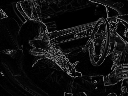

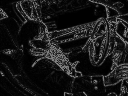

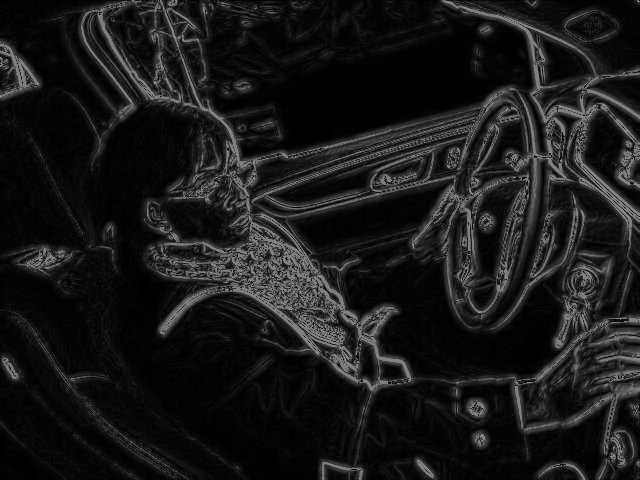

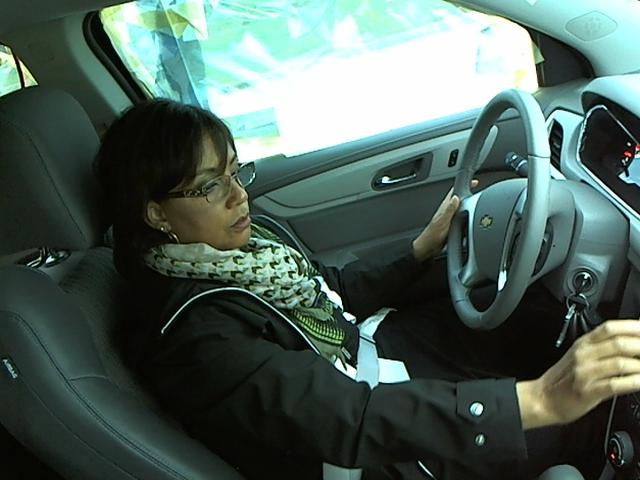

In [2]:


def normalize_image(image) :
    image = image * (255.0/image.max())
    #image /= 255.0
    return image
 
def line_detection( image ) :
        # Creating a custom line filter :
    line_filter = np.array([[-1, -2, -1], 
                            [ 0,  0,  0], 
                            [ 1,  2,  1]])
    stage_1 = ((cv2.filter2D(image, -1, line_filter) + cv2.filter2D(image, -1, line_filter.T))/2).astype(np.uint8)
    
    # New mirrored line filter :
    line_filter = np.array([[  1,   2,   1], 
                            [  0,   0,   0], 
                            [ -1,  -2,  -1]])
    stage_2 = ((cv2.filter2D(image, -1, line_filter) + cv2.filter2D(image, -1, line_filter.T))/2).astype(np.uint8)
    
    return np.maximum(stage_1,stage_2).astype(np.uint8)

def greyed_blured_and_line_detection( image, advanced=False ) :
    # Remove color :
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Blur :
    blured = cv2.GaussianBlur(image,(5, 5), 0)
    
    if not advanced :
        return line_detection(blured)
    else :
        image = line_detection( image )
        blured = line_detection( blured )
        very_blured = cv2.GaussianBlur(image,(11, 11), 0)
        return  np.maximum(
                line_detection(very_blured), 
                np.maximum(image,blured).astype(np.uint8)).astype(np.uint8)

        #np.maximum(image,blured).astype(np.uint8)
    
   
def preprocess_image(img, advanced=False, image_shape=None, flatten=True) :
    img = greyed_blured_and_line_detection(img, advanced=advanced)
    img = normalize_image(img)
    #print('After norm :',img)
    if image_shape is not None : img = cv2.resize(img,(image_shape[1],image_shape[0]))
    #print('After resize :', img)
    if flatten : img = img.flatten()
    
    return img


test_img = cv2.imread("data/imgs/test/img_2.jpg")
test_img = preprocess_image(test_img, image_shape=(128, 96), flatten=False)
print(test_img.shape)

# Let's test the preprocessing suite first :  
test_img = cv2.imread("data/imgs/test/img_2.jpg")
test_img = preprocess_image(test_img)
assert test_img.shape == (307200,)
assert str(test_img) == '[ 0.          2.00787402  4.01574803 ... 18.07086614  4.01574803\n  0.        ]'
test_img = cv2.imread("data/imgs/test/img_2.jpg")
test_img = preprocess_image(test_img, flatten=False)
assert test_img.shape == (480, 640) 
del test_img
#------------------------------------------------------------------------------------------------------
    
print(cv2.imread("data/imgs/test/img_1.jpg").shape)
    
# Converting to grayscale
display_array(
    cv2.resize(
    greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_1.jpg"), advanced=False
    ),(128, 96))
)
display_array(
    cv2.resize(
    greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_1.jpg"), advanced=True
    ),(128, 96))
)
display_array(
    greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_1.jpg"), advanced=True
    )
)
  
display_array(
    cv2.imread("data/imgs/test/img_1.jpg") 
)





---

### Batch Reading : ##


In [4]:

import os, os.path
import pandas as pd

# This method returns the number of files at a given relative path.
def files_in_dir(file_path) :
    # simple version for working with CWD 
    # https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
    return len([name for name in os.listdir(file_path)]) 

assert files_in_dir("./data/imgs/test/") == 79726

# This method generates a ditionary of class names and the number of instances.
def create_class_data_map(path) :
    
    directories = os.listdir(path)
    
    class_data_map = dict()
    
    for c in directories : 
        class_data_map[c] = files_in_dir(path+"/"+c)
        
    return class_data_map
    
# Testing the above :  
assert str(create_class_data_map("./data/imgs/")) == "{'test': 79726, 'train': 10}"

# This method is currently not used. It takes percentage chunks from a provided
# "class_data_map" generated by the method above.
def create_class_data_picks(class_data_map, percentage) :
    
    if percentage is None : return class_data_map
    
    assert percentage <= 1 and percentage >= 0
    
    # https://w3resource.com/python-exercises/dictionary/python-data-type-dictionary-exercise-15.php
    key_min = min(class_data_map.keys(), key=(lambda k: class_data_map[k]))
    print('Min Value: ',class_data_map[key_min])
    
    temp = dict()
    for c, d in class_data_map.items(): temp[c] = int(class_data_map[key_min] * percentage)
        
    return temp
        
def norm(data, norm_type) :
    if norm_type == 'default' :
        return data / 255
    elif norm_type == 'mean_remove' : 
        return data - np.mean(data)
    elif norm_type == 'standard' :
        return ( data - np.mean(data) ) / np.std(data)
    elif norm_type == 'softmax' :
        e_x = np.exp(data - np.max(data))
        return e_x / e_x.sum()
    
    return data

 
    
def load_batch( 
    path, 
    class_picks, 
    size, 
    index, 
    do_label_index_encoding=False, 
    advanced_preprocessing=False,
    image_shape=None,
    flatten=True,
    normalization=None
) : 
    
    batch = []
    labels = []
    class_list = list(class_picks.keys())
    
    read_checker = {c:-size*index for c in class_list}
    
    imgs_list = pd.read_csv("data/driver_imgs_list.csv")
    
    for index, row in imgs_list.iterrows():
        
        c = row['classname']
        
        if read_checker[c] < 0 : read_checker[c] += 1
        elif read_checker[c] < size :
            #print('Loading class : "',c,'"; Already read :', read_checker[c])
            read_checker[c] += 1
            name = row['img']
            img = cv2.imread(path+"/"+c+"/"+name)
            img = preprocess_image(
                img, 
                advanced=advanced_preprocessing,
                image_shape=image_shape,
                flatten=flatten
            ) 
            img = norm(img, normalization)
            
            label = None
            label_index = class_list.index(c)
            if do_label_index_encoding :
                label = label_index
            else :
                label = [0]*len(class_list)
                label[label_index] = 1
                label = np.array(label)
            #print('Appending : B->',img.shape,'; L->',label.shape)
            batch.append(img)
            labels.append(label)
                 
    batch = np.stack(batch)
    labels = np.stack(labels)
    return batch, labels
    
     
b, l = load_batch(
    "data/imgs/train", 
    create_class_data_map("data/imgs/train"),
    size=6, index=0
)

    
assert b.shape == (60, 307200)
assert l.shape == (60, 10)
print(l)   

b, l = load_batch(
    "data/imgs/train", 
    create_class_data_map("data/imgs/train"),
    size=6, index=0, do_label_index_encoding=True
)


assert b.shape == (60, 307200)
assert l.shape == (60,)
    
b, l = load_batch(
    "data/imgs/train", 
    create_class_data_map("data/imgs/train"),
    size=6, index=0, do_label_index_encoding=True, flatten=False
)
 
assert b.shape == (60, 480, 640)
assert l.shape == (60,)

b, l = load_batch(
    "data/imgs/train", 
    create_class_data_map("data/imgs/train"),
    size=6, index=0, do_label_index_encoding=True, flatten=False,
    image_shape=(128, 96)
)
 
assert b.shape == (60, 128, 96)
assert l.shape == (60,)
    
print(l)
del b, l

[[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0

In [38]:
import tensorflow as tf

import keras
from keras.utils.vis_utils import plot_model
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation

def mish(x): return x * (K.tanh(K.softplus(x)))
get_custom_objects().update({'mish': Activation(mish)})

def exec_trial(settings) :
    
    print('Starting trial with the following parameters : \n', settings)
    # Read settings:
    do_conv = settings['convos'] != None
    flatten = not do_conv
    actifuns = settings['actifuns']
    layer_sizes = settings['layer_sizes']
    batch_size = settings['batch_size'] #:= 50
    normalization = settings['normalization']
    

    # Loading (and preprocessing) data :
    train_batch, train_labels = load_batch(
        "data/imgs/train", 
        create_class_data_map("data/imgs/train"), 
        size=batch_size, index=0, 
        #do_label_index_encoding=True, # This is too much for the NN
        advanced_preprocessing=True,
        image_shape=(128, 96),#(256, 192) #640 * 480
        flatten=flatten,
        normalization=normalization
    )
    
    print('Input shape :', train_batch.shape, '; flatten : ', flatten, '; do_conv :', do_conv)
    print('Label shape :',train_labels.shape)
    # reshape for convolution:
    if do_conv : 
        train_batch = train_batch.reshape(list(train_batch.shape) + [1]) 
        print('Input shape for convolution:', train_batch.shape)
        
    batch_size = train_batch.shape[0]
    input_dimension = train_batch.shape[1]
    input_shape = train_batch.shape
    output_dimension = train_labels.shape[len(train_labels.shape)-1]

    print('Input dimension:',input_dimension,'; output_dimension:',output_dimension,';')
    
    model = keras.Sequential()
    if 'mish' in actifuns: model.add(Activation(mish, name='mish'))
    #---------------------------------------
 
    # CONVOLUTION ... WIP
    if do_conv :
        first_iter_done = False
        for convo in settings['convos'] : 
            value = convo['value']
            if convo['type'] == 'conv2d' : 
                if first_iter_done :
                    model.add(
                        keras.layers.Conv2D(
                            value['filters'], 
                            value['kernel_size'],  
                            activation=value['activation'],  
                            padding=value['padding']
                        )
                    )
                else :
                    model.add(
                        keras.layers.Conv2D(
                            value['filters'], 
                            value['kernel_size'], 
                            input_shape=(128, 96, 1),
                            activation=value['activation'],  
                            padding=value['padding']
                        )
                    )
            elif convo['type'] == 'maxpool' : 
                model.add(keras.layers.MaxPooling2D(pool_size=convo['value']['pool_size']))
            elif convo['type'] == 'avgpool' :
                model.add(keras.layers.AveragePooling2D(pool_size=convo['value']['pool_size']))
            else : print('Invalid configuration!!! Convolution type "', convo['type'],'" unknown!')
            first_iter_done = True
        
        model.add(keras.layers.Flatten())
        start = 0
    else :  
        model.add(keras.layers.Dense(layer_sizes[0], input_dim=input_dimension, activation=actifuns[0]))
        start = 1
    
    for i in range(start, len(layer_sizes)) :
        print('Adding layer', i, 'with size ', layer_sizes[i], 'and activation', actifuns[i])
        model.add(keras.layers.Dense(layer_sizes[i], activation=actifuns[i]))

    #model.add(keras.layers.Dropout(0.5))
    model.add(
        keras.layers.Dense(
            output_dimension, 
            activation="softmax"
        )
    )
    
    model.build(input_shape=train_batch.shape)

    # Create model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",#"categorical_crossentropy"
        metrics=["sparse_categorical_accuracy, "accuracy"]
    )
    #print(model.summary())
    #plot_model(model)
    
    print('-----------------------------------------------------\nTraining now...')
    print('train_labels.shape=',train_labels.shape)
    print('train_batch.shape=',train_batch.shape)
    print('input_dimension=',input_dimension)
    print('output_dimension=',output_dimension)
    
    # Configure stopping criterion via early stopping
    # callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

    # Train model
    history_augmented = model.fit(
        train_batch, 
        train_labels,
        validation_split=0.2,
        epochs=100,
        #callbacks=[callback],
        verbose=True
    )

    X_test, y_test = load_batch(
        "data/imgs/train", 
        create_class_data_map("data/imgs/train"), 
        size=batch_size, index=1, 
        #do_label_index_encoding=True,
        advanced_preprocessing=True,
        image_shape=(128, 96),#(256, 192) #640 * 480
        flatten=flatten
    )

    test_loss, test_acc = model.evaluate(X_test, y_test)
    print('Done! Test-loss:', test_loss, '; Test-acc', test_acc, ';')


## Let's do some hyperparameter tuning : ##

In [39]:
trials = [
    {
        'normalization':'softmax',
        'actifuns' : ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
        'layer_sizes' : [256, 64, 32],
        'batch_size' : 10,
        'convos' : [ #64, (8,8), input_shape=(128, 96, 1),activation=hidden_acti,  padding="same"
            {
                'type':'conv2d', #128, (8, 8), activation="selu", padding="same"
                'value' : {
                    'filters': 128,
                    "kernel_size": (4,4),
                    "activation" : "selu",
                    "padding": "same"
                }
            },
            {
                'type':'maxpool', 
                'value' : {
                    'pool_size': (3,3)
                }
            },
            {
                'type':'conv2d', #128, (8, 8), activation="selu", padding="same"
                'value' : {
                    'filters': 64,
                    "kernel_size": (3,3),
                    "activation" : "selu",
                    "padding": "same"
                }
            },
            {
                'type':'maxpool', 
                'value' : {
                    'pool_size': (3,3)
                }
            },
            {
                'type':'conv2d', 
                'value' : {
                    'filters': 16,
                    "kernel_size": (3,3),
                    "activation" : "selu",
                    "padding": "same"
                }
            },
            {
                'type':'maxpool', 
                'value' : {
                    'pool_size': (3,3)
                }
            }
        ]
    },
    {
        'normalization':'standard',
        'actifuns' : ['mish', 'mish', 'mish', 'mish', 'mish', 'mish'],
        'layer_sizes' : [1024, 512, 256, 64, 64, 64],
        'batch_size' : 50,
        'convos' : None
    }
]
   
for trial in trials : exec_trial(trial)


Starting trial with the following parameters : 
 {'normalization': 'softmax', 'actifuns': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'], 'layer_sizes': [256, 64, 32], 'batch_size': 10, 'convos': [{'type': 'conv2d', 'value': {'filters': 128, 'kernel_size': (4, 4), 'activation': 'selu', 'padding': 'same'}}, {'type': 'maxpool', 'value': {'pool_size': (3, 3)}}, {'type': 'conv2d', 'value': {'filters': 64, 'kernel_size': (3, 3), 'activation': 'selu', 'padding': 'same'}}, {'type': 'maxpool', 'value': {'pool_size': (3, 3)}}, {'type': 'conv2d', 'value': {'filters': 16, 'kernel_size': (3, 3), 'activation': 'selu', 'padding': 'same'}}, {'type': 'maxpool', 'value': {'pool_size': (3, 3)}}]}
Input shape : (100, 128, 96) ; flatten :  False ; do_conv : True
Label shape : (100, 10)
Input shape for convolution: (100, 128, 96, 1)
Input dimension: 128 ; output_dimension: 10 ;
Adding layer 0 with size  256 and activation relu
Adding layer 1 with size  64 and activation relu
Adding layer 2 with size  32 

ValueError: in user code:

    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\engine\training.py:759 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:409 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\utils\metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\metrics.py:176 update_state_fn
        return ag_update_state(*args, **kwargs)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\metrics.py:612 update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\metrics.py:3301 sparse_categorical_accuracy
        y_true = array_ops.squeeze(y_true, [-1])
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\util\deprecation.py:507 new_func
        return func(*args, **kwargs)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\ops\array_ops.py:4259 squeeze
        return gen_array_ops.squeeze(input, axis, name)
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\ops\gen_array_ops.py:10043 squeeze
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\Daglemino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 10 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](Cast_1)' with input shapes: [?,10].


In [ ]:
print(model.summary())

In [ ]:
print(test_loss)
print(test_acc)

In [ ]:
print('Result accuracy:',test_acc*10)